<h2>Baseline models</h2>
<h4>Preprocessing tasks - </h4>
1) Unicode to UTF-8 decoding <br>
2) Remove punctuations and numbers <br>
3) Expand word contractions <br>
4) Lemmatization <br>

<h4>Feature extractions - </h4>
TF-IDF<br>
Word2Vec model
<h3> Import packages and set default preferences</h3>


In [175]:
import pandas as pd
import numpy as np
import os
import nltk
import string
import re
import pickle
import itertools
from nltk import pos_tag
from nltk import map_tag
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
#import plotly.plotly as py
#import plotly.figure_factory as ff
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Set jupyter notebook preferences
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

sns.set_palette("hls")
%matplotlib inline

In [6]:
df = pd.read_csv('finaldata.csv',encoding='utf-8')
df.head()
df.shape

,subreddit,text
0,conservative,Washington (CNN) Former FBI Director James Com...
1,conservative,NaN
2,conservative,Kanye West has been having a very Kanye West 2...
3,conservative,As a stoical Robert Bork sat before the Senate...
4,conservative,NaN


(17043, 2)

In [7]:
df.dropna(inplace=True)
df.shape

(16381, 2)

We only need unique posts so we dont mess up adding duplicate tokens and result become biased 

In [110]:
df = df.drop_duplicates()
posts = df.text
posts.shape

(14651,)

### Expanding word contractions in the text and encoding text to UTF-8

In [111]:
with open('expand_dict.pickle','rb') as f:
    expand_dict = pickle.load(f)

In [112]:
'''
expand_contractions takes text and search for word contractions from dictionary keys and expand it from
values from dictionary
'''
def expand_contractions(text, contraction_mapping=expand_dict):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    #print(contraction_mapping.keys())
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

'\nexpand_contractions takes text and search for word contractions from dictionary keys and expand it from\nvalues from dictionary\n'

In [113]:
text_list = []
for post in posts:
    text_list.append(expand_contractions(post))

In [114]:
#encoding from Unicode to UTF-8 and storing into new list
encoded_list=[]
for post in text_list:
    encoded_list.append(unidecode(post))

### Word tokenization and remove punctuations

Tokenization and store cleaned tokens in the list

In [115]:
def word_clean_tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokenlist = []
    for token in tokens:
        token = token.strip().lower()
        pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
        token = pattern.sub('',token)
        if not any(c.isdigit() for c in token):
            tokenlist.append(token)
    return tokenlist

In [116]:
#tokenize the text in the list and store cleaned tokens in the list
tokens = []
for text in encoded_list:
    tokens.append(word_clean_tokenize(text))

### Remove stop words and Lemmatizations

In [117]:
lemmatizer = WordNetLemmatizer()
lem_tokens=[]
stopword_list = nltk.corpus.stopwords.words('english')
for token_list in tokens:
    filter_list = []
    for token in token_list:
        if token not in stopword_list and token.strip():
            filter_list.append(token)
    lem_tokens.append(filter_list)
len(lem_tokens)

14651

Encoding text label to intenger before feeding it to classification models

In [118]:
le = preprocessing.LabelEncoder()
df['subred_num']=le.fit_transform(df['subreddit'])

f:\ms\applied ml\project2\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We cold try establishing classification accuracy on these data

<h3>TF-IDF Vectorizer and classification models</h3>

TF(t) = No of times t appears in a document/ Total number of terms in the doc<br>
IDF(t) = log_e(Total no of doc) / No of doc with term t in it<br><br>
Override the tokenizing phase and pass directly preprocessed tokens to the function

In [119]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False, 
                        sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1')    
features = tfidf.fit_transform(lem_tokens)

Splitting the dataset into Train and test data. Training data would be TF-IDF vectors for the document and output is the ideology labels

In [132]:
X = features
y = df['subred_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [121]:
def plot_confusion_matrix(cm, classes,normalize=False,title='',cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",fontsize=12,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

This function is for estimating the performance of classification model in kfold cross validation by averaging multiple splits

In [179]:
def kfold_performance(classifier, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores=[]
    for train_index, test_index in kfold.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    return scores

Test the performance with set of classifiers beginning with Naive bayes and Logistic regression

In [156]:
clf = {}
clf['LogisticRegression'] = LogisticRegression()
clf['NaiveBayes'] = MultinomialNB()
clf['Random Forest'] = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)
cv_df = pd.DataFrame()
model_tuples = []
for model in clf:
    scores = kfold_performance(clf[model], X, y)
    for fold, accuracy in enumerate(scores):
        model_tuples.append((model, fold, accuracy))
#print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

f:\ms\applied ml\project2\venv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
f:\ms\applied ml\project2\venv\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Scores: [0.5593451568894953, 0.5412969283276451, 0.5146757679180888, 0.557679180887372, 0.5003412969283276, 0.5255972696245734, 0.5146757679180888, 0.5378839590443686, 0.5269624573378839, 0.5372013651877133]
Mean: 0.532
Std: 0.018


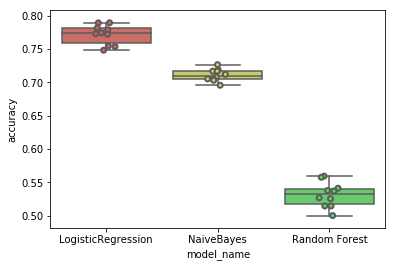

In [158]:
cv_df = pd.DataFrame(model_tuples, columns=['model_name', 'fold', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=5, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

Looks like tree approach doenst work since it is marginally outperformed by other classifiers

Lets plot confusion matrix for Naive bayes and Logistic Regression to evaluate missclassification rate and how each class does with respect to others

f:\ms\applied ml\project2\venv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
f:\ms\applied ml\project2\venv\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

Normalized confusion matrix
[[0.7853717  0.17386091 0.04076739]
 [0.13449634 0.81148002 0.05402364]
 [0.0851735  0.20715037 0.70767613]]


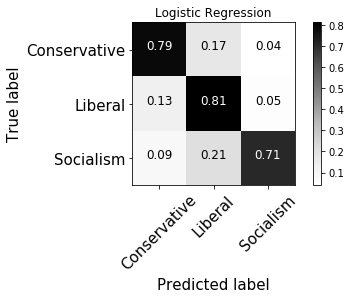

In [159]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
cnf_matrix=confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Conservative','Liberal','Socialism'], normalize=True,title='Logistic Regression')
plt.show()

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

<Figure size 432x288 with 0 Axes>

Normalized confusion matrix
[[0.67086331 0.30755396 0.02158273]
 [0.10410805 0.87113112 0.02476083]
 [0.05573081 0.47003155 0.47423764]]


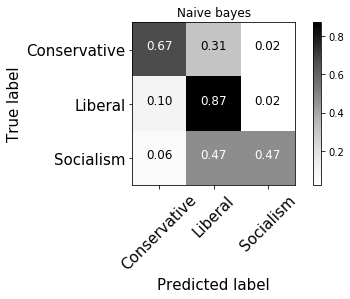

In [160]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
cnf_matrix=confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Conservative','Liberal','Socialism'], normalize=True,title='Naive bayes')
plt.show()

Socialism still have high missclassification rate in both classifiers

<h3>Word2Vec embeddings and Classifiers</h3>

Creating POS tagging to get the linguistic signal how words are used. We can later use only set of tags to train our algorithm

In [162]:
tagged_list = []
for text in lem_tokens:
    pos_tagged = pos_tag(text)
    tagged_pos = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in pos_tagged]
    tagged_list.append(tagged_pos)

Load Google News Word2Vec pretrained model and add weigt to train vector for the token. If it doenst exist then add zero

In [163]:
def word2vec_embed(x_data, pos_filter):
    print('Loading Google news vector...')
    model = word2vec.KeyedVectors.load_word2vec_format('googlenews_word2vec/GoogleNews-vectors-negative300.bin', binary=True)
    x_embedding = []
    
    print('Creating embeddings')
    for token_list in x_data:
        train_vec = np.zeros(300)
        for token in token_list:
            if token[1] in pos_filter:
                try:
                    train_vec += model[token[0]]
                except KeyError:
                    continue
        x_embedding.append(train_vec) 
    return np.array(x_embedding)        

In [164]:
pos_filter = ['NOUN','ADJ','VERB']
arr = word2vec_embed(tagged_list,pos_filter)

Loading Google news vector...
Creating embeddings


In [165]:
arr.shape

(14651, 300)

In [24]:
Every article has weights assigned from google model

In [166]:
data = pd.DataFrame(data=arr)

In [167]:
data=data.join(df['subred_num'].reset_index().drop('index',axis=1))
data.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,subred_num
0,1.022503,9.263481,7.196661,0.713737,-10.198532,-5.373705,6.329010,-11.324772,22.767520,6.896969,...,3.639935,-10.124123,13.274714,-8.389603,-6.505627,6.343185,-17.560234,-2.442932,3.079132,0
1,-0.323867,7.722980,12.684483,32.433552,-16.988693,-10.869745,4.093761,-28.068019,25.313713,20.590340,...,8.180832,-23.305218,0.471176,-14.555885,-25.838142,2.277317,-25.614525,15.118515,2.317825,0
2,77.467317,113.915773,65.519438,245.179375,-94.565128,-109.999386,93.734236,-87.885499,257.730162,121.020763,...,-58.143604,-146.690353,34.986722,-84.497543,-77.428837,90.276260,-132.698345,64.056031,158.318733,0
3,0.672150,8.860280,6.773788,5.557095,-13.995350,-1.298798,14.855133,-13.880474,26.359550,16.415405,...,-5.279045,-10.628357,10.426218,-11.863808,-10.780058,0.959249,-18.345068,6.968060,6.299683,0
4,-0.122070,-0.461533,-1.217285,2.936523,-2.079285,2.565628,3.502319,-0.293793,4.122253,1.102203,...,-0.417969,-0.977966,-1.018799,1.823914,-2.710815,0.975128,-4.760040,-0.759163,0.799683,0


Split the data into training and test data

In [173]:
X = data.iloc[:,:-1].values
y = data['subred_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [180]:
clf = {}
clf['LogisticRegression'] = LogisticRegression() 
clf['Random Forest'] = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)
cv_df = pd.DataFrame()
model_tuples = []
for model in clf:
    scores = kfold_performance(clf[model], X, y)
    for fold, accuracy in enumerate(scores):
        model_tuples.append((model, fold, accuracy))

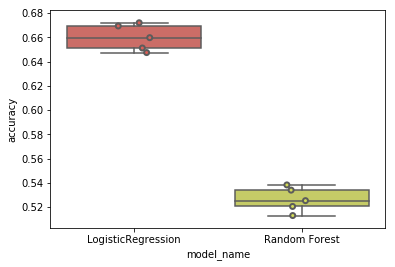

In [181]:
cv_df = pd.DataFrame(model_tuples, columns=['model_name', 'fold', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=5, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

Confusion matrix

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

Normalized confusion matrix
[[0.70083933 0.24040767 0.058753  ]
 [0.28081035 0.65109736 0.06809229]
 [0.16088328 0.18191377 0.65720294]]


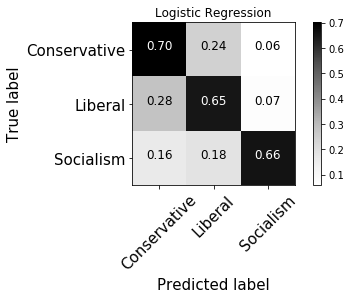

In [182]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
cnf_matrix=confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Conservative','Liberal','Socialism'], normalize=True,title='Logistic Regression')
plt.show()

Some of the misclassified articles could be the one that touch on more than one subjects or lean equally into more than one political ideologies. We need to find the terms that are most correlated with each categories.